In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
from numpy.linalg import pinv
from matplotlib import pyplot as plt
import xgboost as xgb
from sklearn.linear_model import SGDRegressor, LinearRegression

In [8]:
data = pd.read_csv('viscosityData.csv', index_col=0)
data

DES     T/K    V/cP       MCI  Avg Molar   omega
0      DES2  293.15  0.0489  0.051962      87.66  1.7208
1      DES2  293.85  0.0479  0.050127      87.66  1.7208
2      DES2  294.65  0.0459  0.048136      87.66  1.7208
3      DES2  295.45  0.0439  0.046250      87.66  1.7208
4      DES2  296.25  0.0429  0.044462      87.66  1.7208
...     ...     ...     ...       ...        ...     ...
1595  DES45  320.15  0.0370  0.040940     177.72  8.4242
1596  DES45  320.95  0.0360  0.039765     177.72  8.4242
1597  DES45  321.65  0.0350  0.038774     177.72  8.4242
1598  DES45  322.45  0.0340  0.037684     177.72  8.4242
1599  DES45  323.25  0.0330  0.036636     177.72  8.4242

[1600 rows x 6 columns]

In [9]:
'''
T/k inverse with V/cp
MCI direct with V/cp
'''
data.dropna(axis=1,inplace=True)

In [10]:
data.drop(data.columns[:1],axis=1,inplace=True)
data

# Interaction Term (Hypothesis test)
# Normalise first

T/K    V/cP       MCI  Avg Molar   omega
0     293.15  0.0489  0.051962      87.66  1.7208
1     293.85  0.0479  0.050127      87.66  1.7208
2     294.65  0.0459  0.048136      87.66  1.7208
3     295.45  0.0439  0.046250      87.66  1.7208
4     296.25  0.0429  0.044462      87.66  1.7208
...      ...     ...       ...        ...     ...
1595  320.15  0.0370  0.040940     177.72  8.4242
1596  320.95  0.0360  0.039765     177.72  8.4242
1597  321.65  0.0350  0.038774     177.72  8.4242
1598  322.45  0.0340  0.037684     177.72  8.4242
1599  323.25  0.0330  0.036636     177.72  8.4242

[1600 rows x 5 columns]

In [11]:
viscosity = list(data.iloc[:,1])
len(viscosity) == data.shape[0]

True

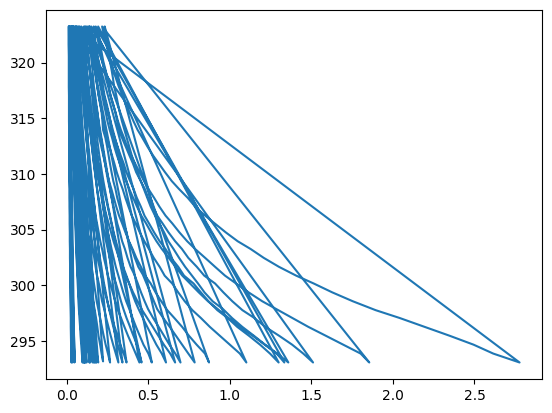

In [12]:
# Relation with Temperature:
temperature = list(data.iloc[:,0])

# Temperature inverse relation with viscosity
plt.plot(viscosity,temperature)

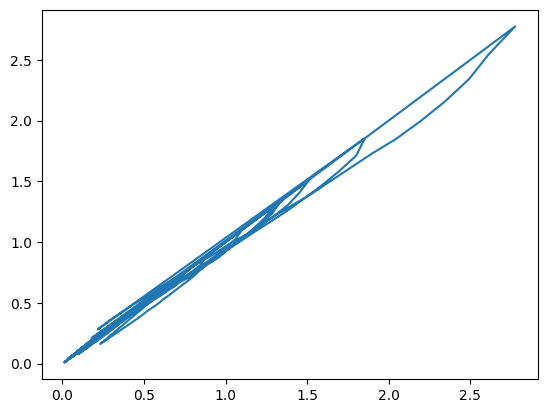

In [13]:
# Relation with Temperature:
MCI = list(data.iloc[:,2])

# MCI linear relation with viscosity
plt.plot(viscosity,MCI)

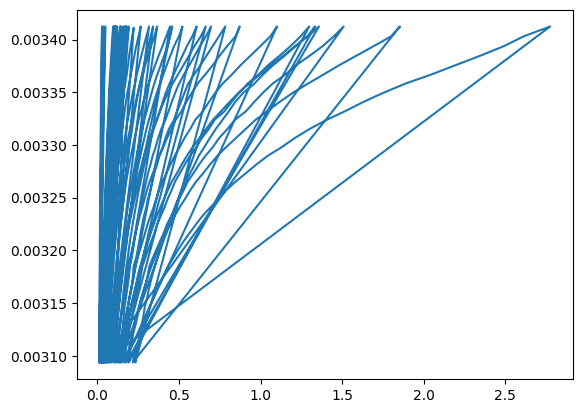

In [14]:
from matplotlib import pyplot as plt

# Relation with Temperature:
temperature = np.array(list(data.iloc[:,0]))
temp_inv = 1 / temperature
# Temperature inverse relation with viscosity
plt.plot(viscosity,temp_inv)

In [15]:
data['inv_Temp'] = temp_inv

In [16]:
data

T/K    V/cP       MCI  Avg Molar   omega  inv_Temp
0     293.15  0.0489  0.051962      87.66  1.7208  0.003411
1     293.85  0.0479  0.050127      87.66  1.7208  0.003403
2     294.65  0.0459  0.048136      87.66  1.7208  0.003394
3     295.45  0.0439  0.046250      87.66  1.7208  0.003385
4     296.25  0.0429  0.044462      87.66  1.7208  0.003376
...      ...     ...       ...        ...     ...       ...
1595  320.15  0.0370  0.040940     177.72  8.4242  0.003124
1596  320.95  0.0360  0.039765     177.72  8.4242  0.003116
1597  321.65  0.0350  0.038774     177.72  8.4242  0.003109
1598  322.45  0.0340  0.037684     177.72  8.4242  0.003101
1599  323.25  0.0330  0.036636     177.72  8.4242  0.003094

[1600 rows x 6 columns]

In [31]:
X = data[['T/K','MCI','Avg Molar',' omega']]
y = data['V/cP']
print(X.shape, y.shape)

(1600, 4) (1600,)


In [32]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
y_test = y_test.to_numpy()

In [ ]:
# Try RandomForest

In [33]:
from sklearn.linear_model import LinearRegression

# Without Regularization

lr = LinearRegression()
lr.fit(X_train, y_train)

pred = lr.predict(X_test)

sum = 0
for i in range(len(pred)):
    sum += abs(pred[i] - y_test[i]) / y_test[i]
mape = sum / len(y_test)
print(f'MAPE: {mape*100}')
print(f'Accuracy: {(1 - mape)*100}')

MAPE: 6.081435378284477
Accuracy: 93.91856462171553


In [34]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

objectives = ['reg:gamma', 'reg:squarederror', 'reg:squaredlogerror', 'reg:tweedie', 'reg:pseudohubererror']

for obj in objectives:
    params = {
        'objective': obj,
        'eval_metric': 'mape',
        'seed': 42
    }

    model = xgb.train(params, dtrain, 1000)
    pred = model.predict(dtest)

    sum = 0
    for i in range(len(pred)):
        sum += abs(pred[i] - y_test[i]) / y_test[i]
    mape = sum / len(y_test)
    print(f'\nObjective: {obj}')
    print(f'MAPE: {mape*100}')
    print(f'Accuracy: {(1 - mape)*100}\n')


Objective: reg:gamma
MAPE: 1.5564951658280748
Accuracy: 98.44350483417192

Objective: reg:squarederror
MAPE: 2.0838630153072897
Accuracy: 97.91613698469271

Objective: reg:squaredlogerror
MAPE: 1.9055959336230686
Accuracy: 98.09440406637692

Objective: reg:tweedie
MAPE: 1.7015920705239334
Accuracy: 98.29840792947606


Objective: reg:pseudohubererror
MAPE: 2.1126469038370495
Accuracy: 97.88735309616295


In [35]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'objective': 'reg:gamma',
    'eval_metric': 'mae',             # Mean Absolute Error
    'seed': 42
}

model = xgb.train(params, dtrain, 100)
pred = model.predict(dtest)

sum = 0
for i in range(len(pred)):
    sum += abs(pred[i] - y_test[i]) / y_test[i]
mape = sum / len(y_test)
print(f'MAPE: {mape*100}')
print(f'Accuracy: {(1 - mape)*100}')

MAPE: 1.5858550650939545
Accuracy: 98.41414493490605


## Inverse of Temperature

In [17]:
X = data[['inv_Temp','MCI','Avg Molar',' omega']]
y = data['V/cP']
print(X.shape, y.shape)

(1600, 4) (1600,)


In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
y_test = y_test.to_numpy()

In [19]:
from sklearn.linear_model import LinearRegression

# Without Regularization

lr = LinearRegression()
lr.fit(X_train, y_train)

pred = lr.predict(X_test)

sum = 0
for i in range(len(pred)):
    sum += abs(pred[i] - y_test[i]) / y_test[i]
mape = sum / len(y_test)
print(f'MAPE: {mape*100}')
print(f'Accuracy: {(1 - mape)*100}')

MAPE: 6.066311219358881
Accuracy: 93.93368878064112


In [20]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

objectives = ['reg:gamma', 'reg:squarederror', 'reg:squaredlogerror', 'reg:tweedie', 'reg:pseudohubererror']

for obj in objectives:
    params = {
        'objective': obj,
        'eval_metric': 'mape',
        'seed': 42
    }

    model = xgb.train(params, dtrain, 1000)
    pred = model.predict(dtest)

    sum = 0
    for i in range(len(pred)):
        sum += abs(pred[i] - y_test[i]) / y_test[i]
    mape = sum / len(y_test)
    print(f'\nObjective: {obj}')
    print(f'MAPE: {mape*100}')
    print(f'Accuracy: {(1 - mape)*100}\n')


Objective: reg:gamma
MAPE: 1.5653588260717874
Accuracy: 98.43464117392821

Objective: reg:squarederror
MAPE: 2.1084408204389136
Accuracy: 97.89155917956109

Objective: reg:squaredlogerror
MAPE: 1.9049059853216512
Accuracy: 98.09509401467835

Objective: reg:tweedie
MAPE: 1.6956331292405167
Accuracy: 98.30436687075948


Objective: reg:pseudohubererror
MAPE: 2.1197447403468814
Accuracy: 97.88025525965311


## Dropping Avg Molar and omega

In [43]:
X = data[['inv_Temp','MCI']]
y = data['V/cP']
print(X.shape, y.shape)

(1600, 2) (1600,)


In [44]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
y_test = y_test.to_numpy()

# 5 Fold and avg MAPE

In [45]:
from sklearn.linear_model import LinearRegression

# Without Regularization

lr = LinearRegression()
lr.fit(X_train, y_train)

pred = lr.predict(X_test)

sum = 0
for i in range(len(pred)):
    sum += abs(pred[i] - y_test[i]) / y_test[i]
mape = sum / len(y_test)
print(f'MAPE: {mape*100}')
print(f'Accuracy: {(1 - mape)*100}')

MAPE: 6.871144283774912
Accuracy: 93.12885571622509


In [46]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

objectives = ['reg:gamma', 'reg:squarederror', 'reg:squaredlogerror', 'reg:tweedie', 'reg:pseudohubererror']

for obj in objectives:
    params = {
        'objective': obj,
        'eval_metric': 'mape',
        'seed': 42
    }

    model = xgb.train(params, dtrain, 1000)
    pred = model.predict(dtest)

    sum = 0
    for i in range(len(pred)):
        sum += abs(pred[i] - y_test[i]) / y_test[i]
    mape = sum / len(y_test)
    print(f'\nObjective: {obj}')
    print(f'MAPE: {mape*100}')
    print(f'Accuracy: {(1 - mape)*100}\n')


Objective: reg:gamma
MAPE: 5.31015447788077
Accuracy: 94.68984552211923

Objective: reg:squarederror
MAPE: 5.0321175267572
Accuracy: 94.96788247324281

Objective: reg:squaredlogerror
MAPE: 5.029717739088381
Accuracy: 94.97028226091162

Objective: reg:tweedie
MAPE: 5.329030972332137
Accuracy: 94.67096902766787

Objective: reg:pseudohubererror
MAPE: 5.068270715272853
Accuracy: 94.93172928472715


In [49]:
ilog_temp = np.log(list(data.iloc[:,0]))
data['ilog_temp'] = ilog_temp
data

T/K    V/cP       MCI  Avg Molar   omega  inv_Temp  ilog_temp
0     293.15  0.0489  0.051962      87.66  1.7208  0.003411   5.680684
1     293.85  0.0479  0.050127      87.66  1.7208  0.003403   5.683069
2     294.65  0.0459  0.048136      87.66  1.7208  0.003394   5.685788
3     295.45  0.0439  0.046250      87.66  1.7208  0.003385   5.688500
4     296.25  0.0429  0.044462      87.66  1.7208  0.003376   5.691204
...      ...     ...       ...        ...     ...       ...        ...
1595  320.15  0.0370  0.040940     177.72  8.4242  0.003124   5.768790
1596  320.95  0.0360  0.039765     177.72  8.4242  0.003116   5.771285
1597  321.65  0.0350  0.038774     177.72  8.4242  0.003109   5.773464
1598  322.45  0.0340  0.037684     177.72  8.4242  0.003101   5.775948
1599  323.25  0.0330  0.036636     177.72  8.4242  0.003094   5.778426

[1600 rows x 7 columns]

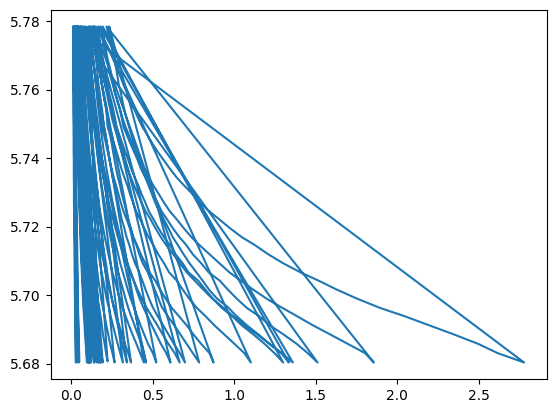

In [50]:
plt.plot(viscosity, ilog_temp)